## Data

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [1]:
DIMS = 20
SAMPLES = 12000

In [4]:
X_first_half = torch.rand((SAMPLES, int(DIMS/2))) * 100 - 22
X_second_half = torch.randn((SAMPLES, int(DIMS/2))) * 32 + 15

X = torch.cat([X_first_half, X_second_half], dim=1)
X.shape

torch.Size([12000, 20])

In [5]:
w = torch.rand((DIMS,)) * 3 - 2
w

tensor([-1.0299,  0.4102, -1.9136,  0.8178,  0.5015, -1.2499, -0.0582, -1.8222,
        -1.5028, -1.6581, -1.2213, -1.2845,  0.1338,  0.0213,  0.2986, -0.7750,
        -1.8383,  0.4476, -0.0876,  0.4116])

In [20]:
X_transformed = torch.matmul(X, w)

Y = X_transformed ** 2 + X_transformed * torch.cos(X_transformed) + torch.randn(len(X_transformed)) * 10

X.shape, Y.shape

(torch.Size([12000, 20]), torch.Size([12000]))

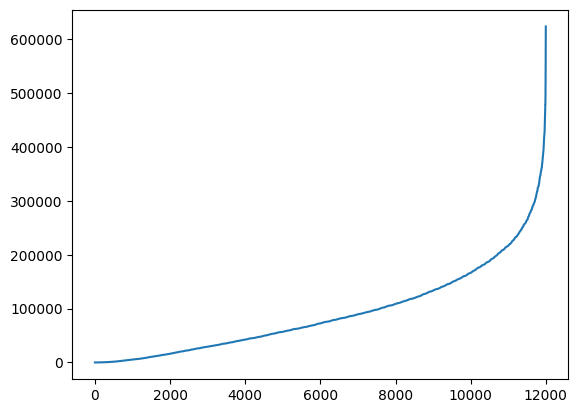

In [21]:
plt.plot(range(len(Y)), torch.sort(Y).values)